In [1]:
import copy
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
from torch import nn
from sklearn.metrics import accuracy_score
from umap import UMAP

In [2]:
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Category10

In [3]:
from cassava.transforms import get_test_transforms

In [4]:
%matplotlib inline

In [9]:
parameters = context.catalog.load('parameters')

2020-12-30 12:41:19,238 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [5]:
model = context.catalog.load('model').eval()

2020-12-30 12:40:52,890 - kedro.io.data_catalog - INFO - Loading data from `model` (TorchLocalModel)...


In [6]:
model.load_state_dict(torch.load('../data/06_models/cv_folds/model_fold_0.pt'))

<All keys matched successfully>

In [7]:
model.to('cuda')

extractor = copy.deepcopy(model)

extractor.eval()
extractor.to('cuda')

extractor.trunk.classifier = nn.Identity()

In [10]:
train = context.catalog.load('train')
train.transform = get_test_transforms(parameters['classifier']['test_width'], parameters['classifier']['test_height'])
loader = torch.utils.data.DataLoader(train, batch_size=10, num_workers=4)

2020-12-30 12:41:34,332 - kedro.io.data_catalog - INFO - Loading data from `train` (ImageOneFolderDataSet)...


In [11]:
vectors = []
labels = []
predictions = []
for batch in tqdm(loader): 
    images, batch_labels = batch
    images = images.to('cuda')
    predictions += model.predict(images).tolist()
    
    vectors += extractor(images).tolist()
    labels += batch_labels.tolist()
    
predictions = np.array(predictions)
labels = np.array(labels)
sources = train.sources
success = np.equal(predictions, labels)

100%|██████████| 2634/2634 [04:19<00:00, 10.16it/s]


In [12]:
assert (train.labels == labels).all()

In [13]:
reducer = UMAP(random_state=42)
transformed = reducer.fit_transform(vectors)
tr_x, tr_y = transformed[:, 0], transformed[:, 1]

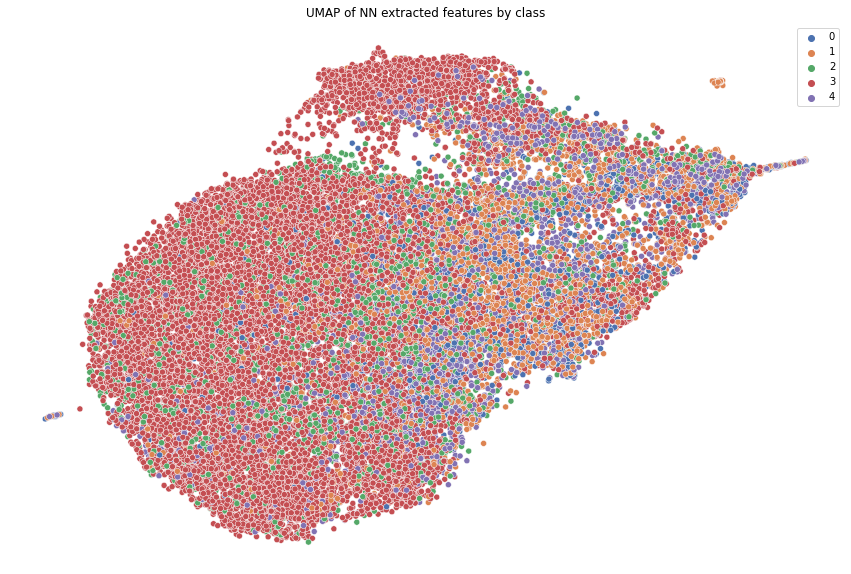

In [14]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=tr_x, y=tr_y, hue=np.array(labels), palette="deep")
plt.axis('off')
plt.title('UMAP of NN extracted features by class')
plt.show()

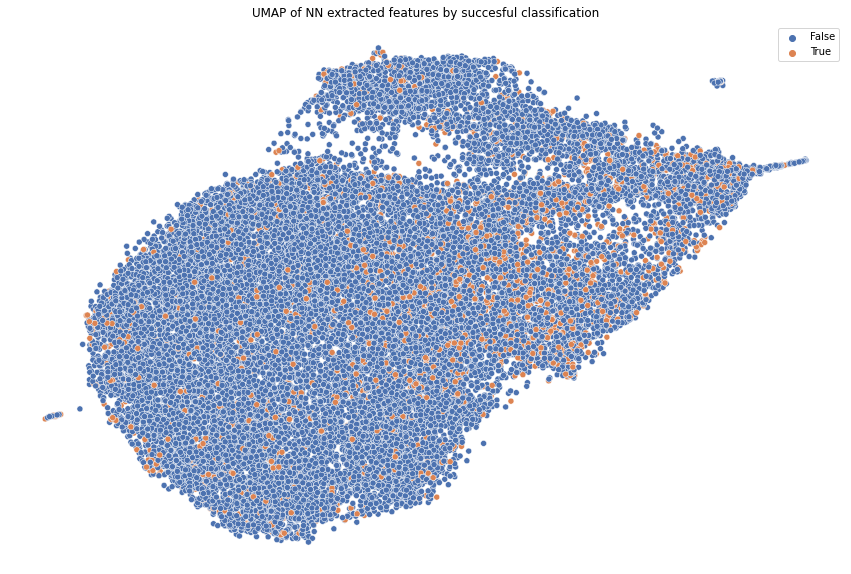

In [15]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=tr_x, y=tr_y, hue=success, palette="deep")
plt.axis('off')
plt.title('UMAP of NN extracted features by succesful classification')
plt.show()

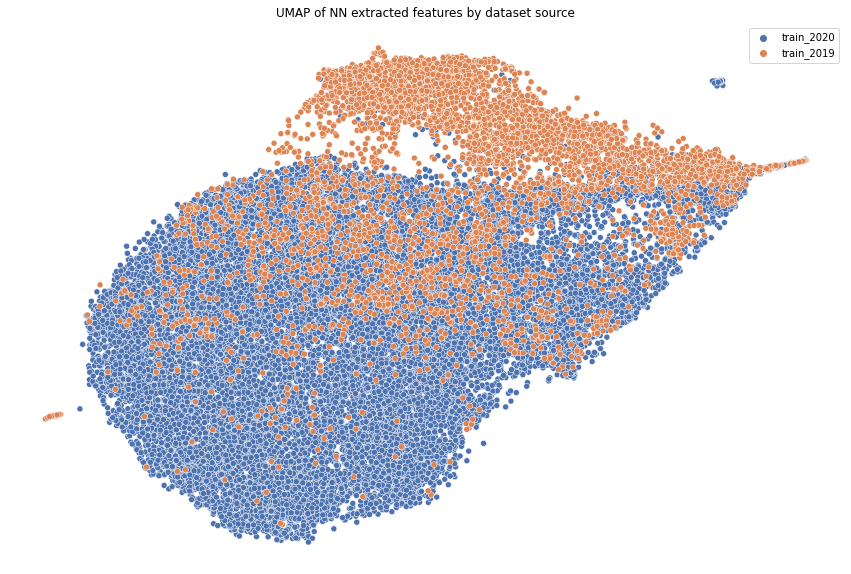

In [16]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=tr_x, y=tr_y, hue=sources, palette="deep")
plt.axis('off')
plt.title('UMAP of NN extracted features by dataset source')
plt.show()

In [20]:
label_num_to_disease_map = {0: "Cassava Bacterial Blight (CBB)", 
                            1: "Cassava Brown Streak Disease (CBSD)", 
                            2: "Cassava Green Mottle (CGM)", 
                            3: "Cassava Mosaic Disease (CMD)", 
                            4: "Healthy"}

In [21]:
base_dir = '../data/03_primary/train'
img_paths = [os.path.join(os.getcwd(), base_dir, img_id) for img_id in train.image_ids]
descs = [f'{l.item()} ({label_num_to_disease_map[l.item()]})' for l in labels]

In [22]:
source = ColumnDataSource(data=dict(
    x=tr_x,
    y=tr_y,
    label=[str(l) for l in labels],
    prediction=[str(p) for p in predictions],
    success=[str(s) for s in success],
    source=[str(s) for s in sources],
    desc=descs,
    imgs=img_paths
))

In [23]:
TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="200" alt="@imgs" width="200"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <div style="font-size: 15px; font-weight: bold;">Label: @label</div>
            <div style="font-size: 15px; font-weight: bold;">Predicted: @prediction</div>
            <div style="font-size: 12px; font-weight: bold;">Success: @success</div>
            <div style="font-size: 12px;">Source: @source</div>
            <div style="font-size: 12px;">@desc</div>
            <div style="font-size: 12px; color: #966;">[$index]</div>
        </div>
    </div5
"""

In [24]:
p = figure(plot_width=1600, 
           plot_height=800, 
           tooltips=TOOLTIPS,
           title="UMAP: Mouse over the dots")

mapper = factor_cmap(field_name='label', palette=Category10[5], factors=['0', '1', '2', '3', '4'])

p.scatter('x', 'y', 
         color=mapper,
         marker=factor_mark('success', ['circle', 'x'], [str(True), str(False)]),
         size=10, 
         fill_alpha=0.5,
         legend_field="desc",
         source=source)

p.legend.orientation = "vertical"
p.legend.location = "top_right"

show(p)